In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, to_date
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("AadhaarAnalytics").getOrCreate()

In [3]:
file_path = r"C:\Users\Shivam\Downloads\Enrolment_data_March-July (2).csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- Date: string (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Pincode: integer (nullable = true)
 |-- Age_0_5: integer (nullable = true)
 |-- Age_5_17: integer (nullable = true)
 |-- Age_18_greater: integer (nullable = true)

+----------+-------------+---------+-------+-------+--------+--------------+
|      Date|        State| District|Pincode|Age_0_5|Age_5_17|Age_18_greater|
+----------+-------------+---------+-------+-------+--------+--------------+
|15-03-2025|        Assam| Marigaon| 782104|     10|      11|            46|
|15-03-2025|        Assam|Kokrajhar| 783350|     10|      16|            18|
|15-03-2025|Uttar Pradesh|     Agra| 282010|     10|      49|            19|
|15-03-2025|Uttar Pradesh|     Agra| 282005|     10|      66|            17|
|20-03-2025|        Bihar|Sitamarhi| 843330|     10|      12|            19|
+----------+-------------+---------+-------+-------+--------+--------------+
only showing top 5 r

In [4]:
df = df.withColumn("Total_Enrolments", col("Age_0_5") + col("Age_5_17") + col("Age_18_greater"))

In [5]:
overall_total = df.agg(_sum("Total_Enrolments").alias("Overall_Total")).collect()[0]["Overall_Total"]
print("Overall Aadhaar Enrolments:", overall_total)

Overall Aadhaar Enrolments: 1291042


In [11]:
#Top 5 Pincodes with Highest Enrolments
pincodewise = df.groupBy("Pincode").agg(_sum("Total_Enrolments").alias("Pincode_Total")) \
                .orderBy(col("Pincode_Total").desc())

print("Top 5 Pincodes by Aadhaar Enrolments:")
pincodewise.show(5, truncate=False)


Top 5 Pincodes by Aadhaar Enrolments:
+-------+-------------+
|Pincode|Pincode_Total|
+-------+-------------+
|244001 |10380        |
|793119 |9690         |
|202001 |8574         |
|110059 |7424         |
|244901 |6594         |
+-------+-------------+
only showing top 5 rows


In [12]:
#State with Minimum Enrolments
min_state = df.groupBy("State").agg(_sum("Total_Enrolments").alias("State_Total")) \
              .orderBy(col("State_Total").asc())

print("State with Minimum Aadhaar Enrolments:")
min_state.show(1, truncate=False)


State with Minimum Aadhaar Enrolments:
+-----+-----------+
|State|State_Total|
+-----+-----------+
|Goa  |42         |
+-----+-----------+
only showing top 1 row


In [13]:
#Average Enrolments per District
avg_district = df.groupBy("District").agg((_sum("Total_Enrolments")/1).alias("District_Total")) \
                 .agg({"District_Total":"avg"})

print("Average Aadhaar Enrolments per District:")
avg_district.show()


Average Aadhaar Enrolments per District:
+-------------------+
|avg(District_Total)|
+-------------------+
| 2967.9126436781607|
+-------------------+



C:\Users\Shivam\AppData\Local\Temp\ipykernel_22804\610869443.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="State_Total", y="State", data=statewise_pd.head(10), palette="viridis")


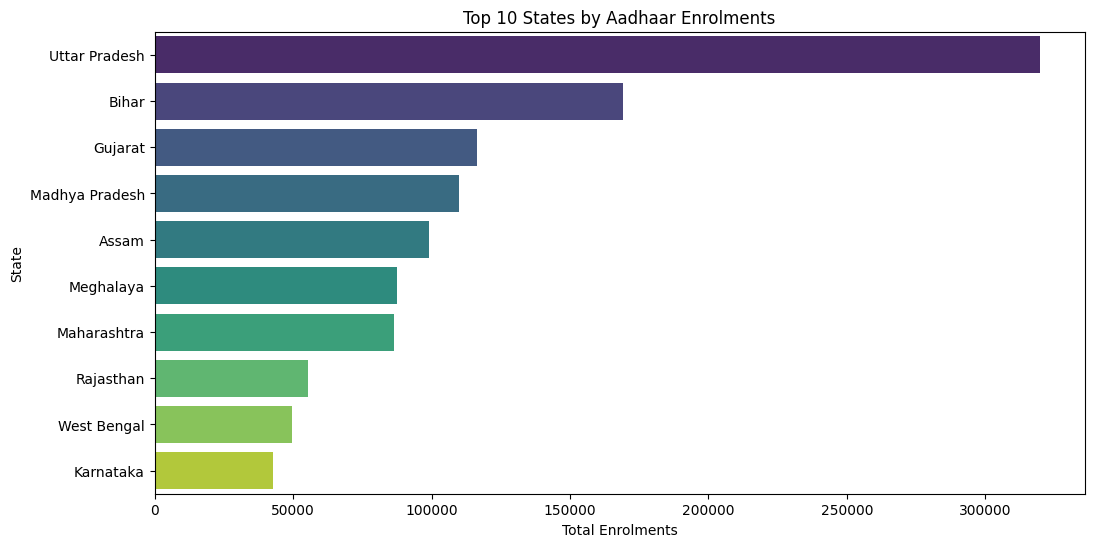

In [6]:
# Top 10 States by Enrolments
statewise = df.groupBy("State").agg(_sum("Total_Enrolments").alias("State_Total")) \
              .orderBy(col("State_Total").desc())

statewise_pd = statewise.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="State_Total", y="State", data=statewise_pd.head(10), palette="viridis")
plt.title("Top 10 States by Aadhaar Enrolments")
plt.xlabel("Total Enrolments")
plt.ylabel("State")
plt.show()


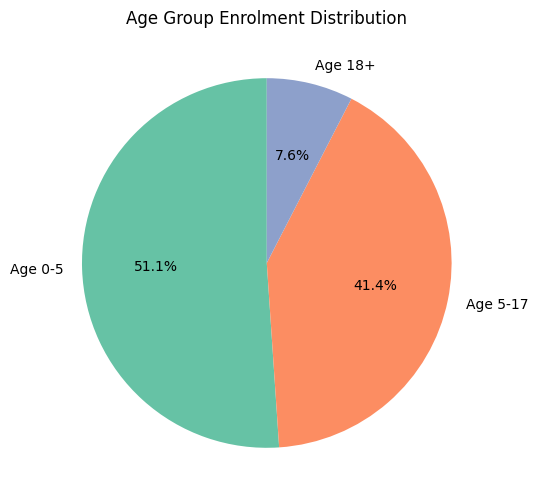

In [7]:
# Age Group Distribution
age_groups = df.agg(
    _sum("Age_0_5").alias("Age 0-5"),
    _sum("Age_5_17").alias("Age 5-17"),
    _sum("Age_18_greater").alias("Age 18+")
).toPandas().T

age_groups.columns = ["Count"]

plt.figure(figsize=(6,6))
plt.pie(age_groups["Count"], labels=age_groups.index, autopct="%1.1f%%", startangle=90, colors=sns.color_palette("Set2"))
plt.title("Age Group Enrolment Distribution")
plt.show()


C:\Users\Shivam\AppData\Local\Temp\ipykernel_22804\2540340821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="District_Total", y="District", data=districtwise_pd.head(10), palette="cubehelix")


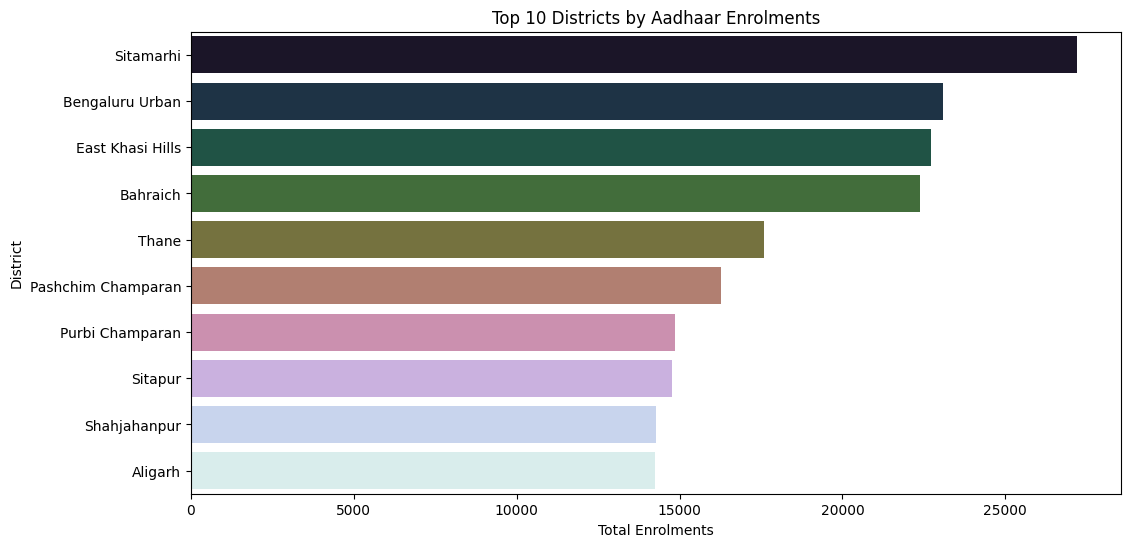

In [8]:
# Top 10 Districts by Enrolments
districtwise = df.groupBy("District").agg(_sum("Total_Enrolments").alias("District_Total")) \
                 .orderBy(col("District_Total").desc())

districtwise_pd = districtwise.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="District_Total", y="District", data=districtwise_pd.head(10), palette="cubehelix")
plt.title("Top 10 Districts by Aadhaar Enrolments")
plt.xlabel("Total Enrolments")
plt.ylabel("District")
plt.show()


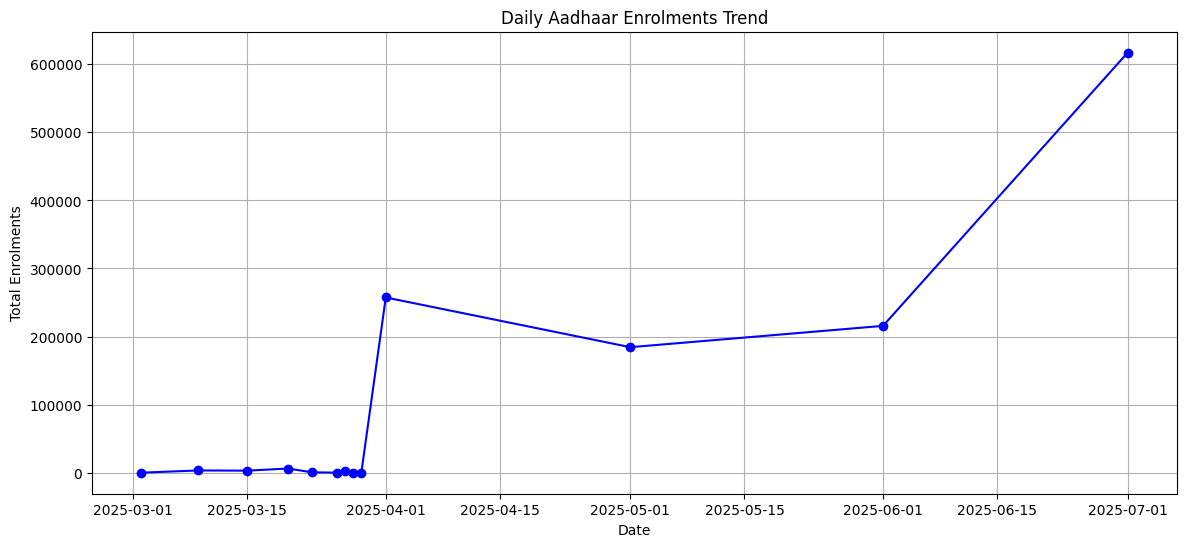

In [9]:
# Enrolments Over Time
df = df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))

time_trend = df.groupBy("Date").agg(_sum("Total_Enrolments").alias("Daily_Total")) \
               .orderBy("Date")

time_trend_pd = time_trend.toPandas()

plt.figure(figsize=(14,6))
plt.plot(time_trend_pd["Date"], time_trend_pd["Daily_Total"], marker="o", linestyle="-", color="blue")
plt.title("Daily Aadhaar Enrolments Trend")
plt.xlabel("Date")
plt.ylabel("Total Enrolments")
plt.grid(True)
plt.show()


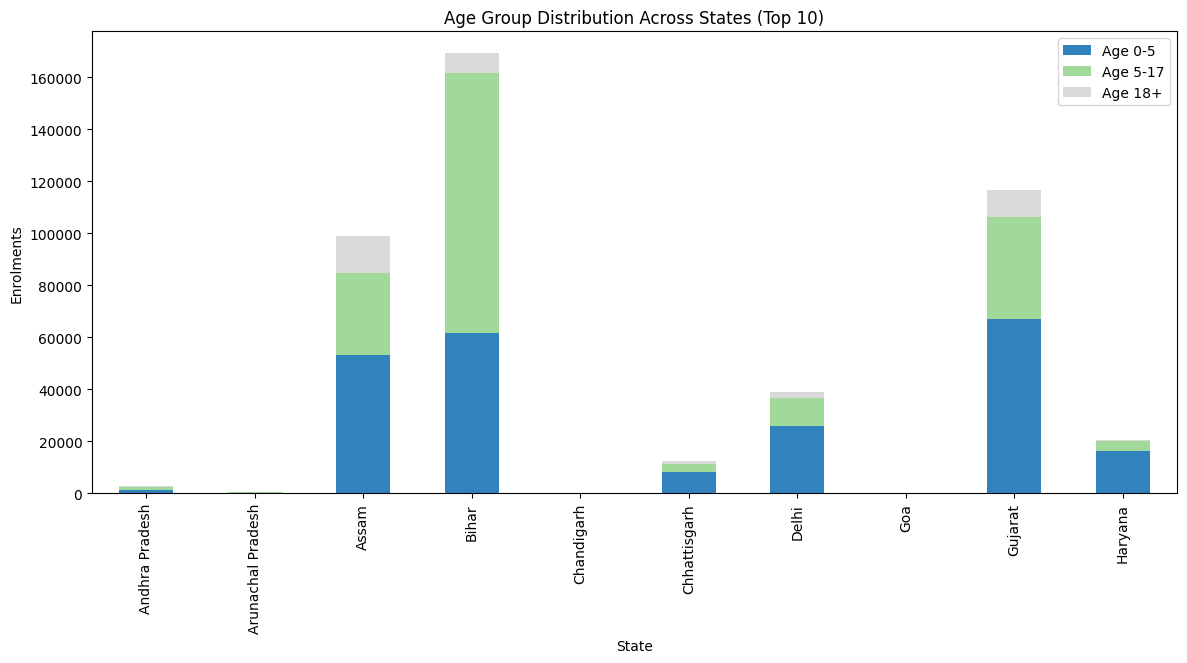

In [10]:
# Statewise Age Distribution
state_age = df.groupBy("State").agg(
    _sum("Age_0_5").alias("Age 0-5"),
    _sum("Age_5_17").alias("Age 5-17"),
    _sum("Age_18_greater").alias("Age 18+")
).orderBy("State")

state_age_pd = state_age.toPandas().set_index("State")

state_age_pd.head(10).plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20c")
plt.title("Age Group Distribution Across States (Top 10)")
plt.ylabel("Enrolments")
plt.show()
